In [5]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm

from scipy.stats import gaussian_kde

from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore
from utils.dataloading import get_data, get_graph_data


In [6]:
import matplotlib as mpl

In [7]:
plt.rc('font', family='serif',)


In [8]:
from matplotlib import rc

In [9]:
data = get_zeolite('RHO', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'RHO')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [10]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [11]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [12]:
from sklearn.linear_model import LinearRegression as LR

In [13]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [14]:
yhat = lr.predict(testX)

In [15]:
atoms.shape, hoa.shape

((1212, 48), (1212,))

In [16]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [17]:
lr_mse, lr_mae

(2.416157840969855, 1.2038933675275088)

In [18]:
hoa.min(), hoa.max()

(17.526, 39.5594)

In [19]:
title_size=7.5
label_size=7

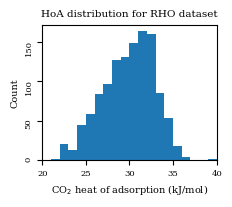

In [20]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(15,41,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for RHO dataset', fontsize=title_size)
plt.xlim(20,40)
plt.savefig('figures/datadist_rho.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [21]:
uniq = np.unique(atoms.sum(1))
uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [22]:
atoms.shape

(1212, 48)

In [23]:
n_ats = atoms.sum(1)


In [24]:
n_ats.shape, hoa.shape

((1212,), (1212,))

In [25]:
x = []
y = []
y_ci_min = []
y_ci_max = []
for i in np.unique(n_ats):
    _x = hoa[n_ats==i]

    x.append(i)
    y.append(np.mean(_x))

    b,t = np.quantile(_x, [0.05, 0.95])
    y_ci_min.append(b)
    y_ci_max.append(t)
    

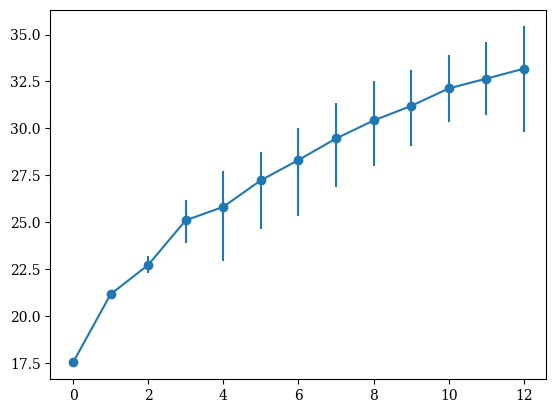

In [26]:
plt.scatter(x,y)
plt.plot(x,y)
plt.vlines(x, y_ci_min, y_ci_max)

In [27]:
hoa_x = np.tile(np.linspace(15,41,27)[:,None], (1,12))
hoa_y = np.tile(np.arange(0,12,1)[None], (hoa_x.shape[0],1))


In [28]:
hoa_x.shape

(27, 12)

In [29]:
zi = np.zeros((len(hoa_x),12))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum() -1
    if n_als == -1:
        n_als = 0

    for _x in range(len(hoa_x)):
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [30]:
sum(zi > 0)

array([2, 2, 4, 7, 6, 8, 8, 9, 8, 6, 7, 9])

In [31]:
zi = zi/zi.sum(0)[None]

In [32]:
uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

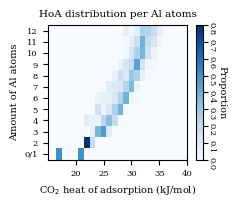

In [33]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')

plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,12,1), ['0/1',2,3,4,5,6,7,8,9,10,11,12], fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(15,40)
plt.ylim(-0.5,11.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_rho.pdf', dpi=1200, bbox_inches="tight")

In [34]:
hoa_x.shape, hoa_y.shape, zi.shape

((27, 12), (27, 12), (27, 12))

In [35]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')


mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True).to('cuda')

In [36]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [37]:
_mae_p = []
_mse_p = []

_mae_p2 = []
_mse_p2 = []
    
for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/RHO/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p.append(_mae)
    _mse_p.append(_mse)

    mpnn2.load_state_dict(torch.load(f'model_data_random2/RHO/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p2.append(_mae)
    _mse_p2.append(_mse)

mae_p  = np.mean(_mae_p)
mse_p = np.mean(_mse_p)
mae_p2  = np.mean(_mae_p2)
mse_p2 = np.mean(_mse_p2)


mae_p_ci = get_95_CI(_mae_p)
mse_p_ci = get_95_CI(_mse_p)
mae_p2_ci = get_95_CI(_mae_p2)
mse_p2_ci = get_95_CI(_mse_p2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


In [38]:
mae_p, mae_p2, mse_p, mse_p2

(2.5649855196475984, 2.329471117258072, 10.691980683803559, 8.845356380939483)

In [39]:
_mae_p2

[1.170682668685913,
 1.7025291919708252,
 1.6165841817855835,
 3.8008131980895996,
 1.8865958452224731,
 1.2932355403900146,
 5.918986797332764,
 0.9037892818450928,
 0.8062425255775452,
 4.195251941680908]

In [40]:
mae_p_ci, mae_p2_ci, mse_p_ci, mse_p2_ci

(1.1142422132036218, 1.007016256612931, 7.63626059081514, 6.792947194096055)

In [41]:
best_idx = np.argmin(_mae_p2)
print(best_idx)
mpnn2.load_state_dict(torch.load(f'model_data_random2/RHO/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn2.predict(testloader)

8


In [42]:
n_ats = testloader.dataset.X.numpy().sum((-1,-2))

In [43]:
y_pred = y_pred.numpy()
y_true = y_true.numpy()

In [44]:
cnt = 0
mcvsml = np.zeros((len(np.unique(n_ats)), 3))
for uniq in np.unique(n_ats):
    mask = n_ats == uniq
    mc = np.mean(y_true[mask])
    ml = np.mean(y_pred[mask])
    mcvsml[cnt] = [uniq, mc, ml]
    cnt +=1

np.savetxt('rho_al_mc_ml.csv', mcvsml, delimiter=',')

In [45]:
scatter = np.zeros((len(y_pred), 2))
scatter[:,0] = y_true
scatter[:,1] = y_pred

np.savetxt('scatter_mc_ml.csv', scatter, delimiter=',')

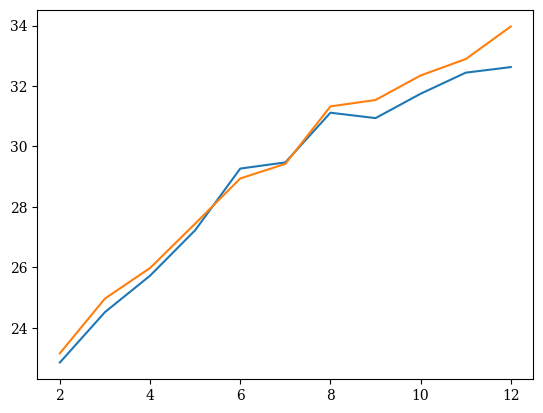

In [46]:
plt.plot(mcvsml[:,0], mcvsml[:,1])
plt.plot(mcvsml[:,0], mcvsml[:,2])

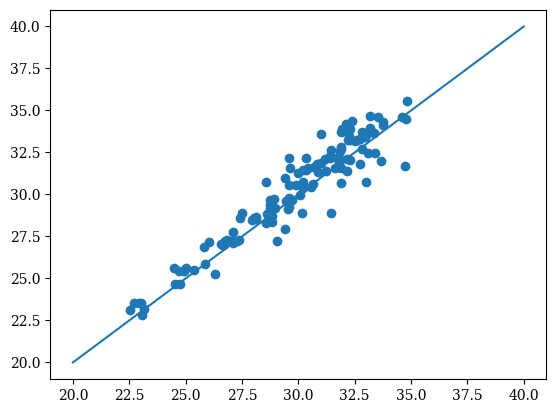

In [47]:
plt.scatter(scatter[:,0], scatter[:,1])
plt.plot([20,40],[20,40])

In [52]:
def get_edges(X,A):

    edge_x, edge_y = [],[]
    
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                ix, iy = X[i,[0,1]].copy()

                jx, jy = X[j,[0,1]].copy()
            
                if jx - ix > 0.5:
                    jx -= 1
                elif jx - ix < -0.5:
                    jx += 1

                if jy - iy > 0.5:
                    jy -= 1
                elif jy - iy < -0.5:
                    jy += 1

                
                
                edge_x.append((ix,jx))
                edge_y.append((iy,jy))
                
                
    return edge_x, edge_y

def plot_edges(X,A,ax):

    ex, ey = get_edges(X,A)    
    for i in range(len(ex)):

        ax.plot(ex[i], ey[i], c='black', zorder=-100)

In [62]:
X_pore

array([[0.5, 0.5, 0.5],
       [0. , 0. , 0. ]])

In [59]:
hid

array([[13.536642],
       [13.536642]], dtype=float32)

[[14.280504]
 [14.280504]]


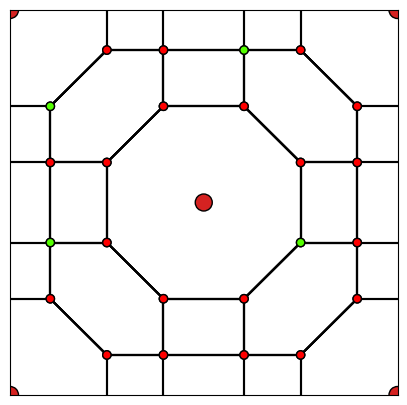

In [72]:
_X, _bonds, _X_p, _bonds_sp, _bonds_ps, _y = next(iter(testloader))
mpnn2.eval()
with torch.no_grad():
    hid = mpnn2.forward(_X.float().cuda(), _bonds.float().cuda(), _X_p.float().cuda(), _bonds_sp.float().cuda(), _bonds_ps.float().cuda())[4].cpu().numpy()

print(hid)
fig, ax = plt.subplots(figsize=(5,5))
plot_edges(X,A,ax)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xticks([],[])
ax.set_yticks([],[])
ax.scatter(X[:,0], X[:,1], c=_X[0],edgecolors='black', cmap='prism')
pr = ax.scatter(X_pore[:,0], X_pore[:,1], c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=20)
ax.scatter(X_pore[:,0]+1, X_pore[:,1], c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=20)
ax.scatter(X_pore[:,0], X_pore[:,1]+1, c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=20)
ax.scatter(X_pore[:,0]+1, X_pore[:,1]+1, c=hid , s=150, cmap='Reds',edgecolors='black', vmin=0, vmax=20)
fig.savefig('rho_pores.png', dpi=500, bbox_inches='tight')

(array([ 2.,  5., 13., 13.,  8., 13., 15., 13., 11., 11., 18.]),
 array([ 2.        ,  2.90909091,  3.81818182,  4.72727273,  5.63636364,
         6.54545455,  7.45454545,  8.36363636,  9.27272727, 10.18181818,
        11.09090909, 12.        ]),
 <BarContainer object of 11 artists>)

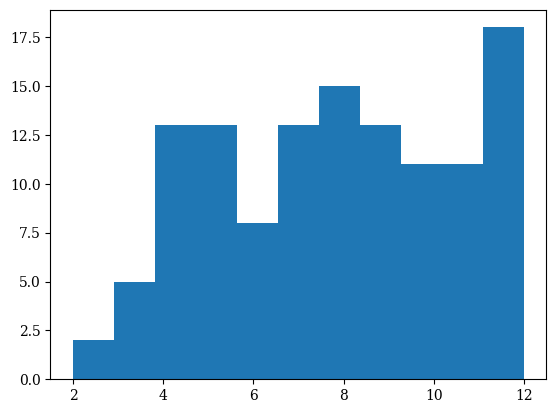

In [40]:
plt.hist(n_ats, bins=len(np.unique(n_ats)))

In [79]:
#np.save('pred_rho.npy', y_pred.numpy())

In [38]:
np.save('true_rho.npy', y_true.numpy())

In [78]:
from scipy.interpolate import griddata

In [39]:
np.save('ats_rho.npy',testloader.dataset.X.numpy())

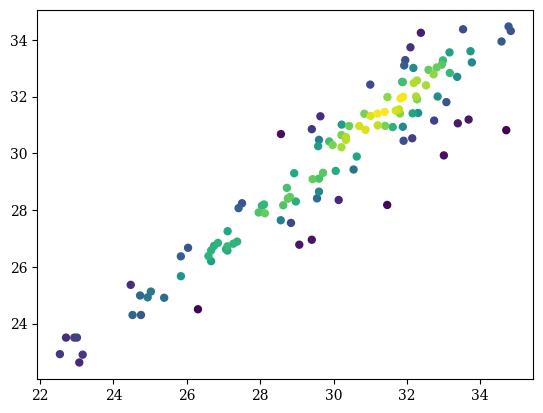

In [68]:
_y_pred = y_pred.numpy()
_y_true = y_true.numpy()
xy = np.vstack([_y_true,_y_pred])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = _y_true[idx], _y_pred[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=25)
plt.show()

In [55]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(22.6325), tensor(34.4694), tensor(22.5393), tensor(34.8336))

In [56]:
Z = torch.ones_like(y_pred)

In [57]:
nn = 60
xmin = 20
xmax = 37
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [58]:
#xi.shape, yi.shape, xi, yi

In [59]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [60]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_4152\4064518472.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


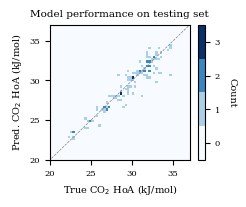

In [61]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

#plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_itw.pdf', dpi=1200, bbox_inches="tight")

In [68]:
color = np.zeros((X.shape[0],))
for i in range(len(X)):
    
    for j in range(4):
        
        for k in range(ref.shape[0]):
            
            if np.abs(X[i] - (np.mod(X[j]@ref[k] + tra[k], 1))).sum() < 0.001:
                
                color[i] = j
                
                break


color2 = np.zeros((X_pore.shape[0],))
for i in range(len(X_pore)):
    
    for j in [0,1]:
        
        for k in range(ref.shape[0]):
            
            if np.abs(X_pore[i] - (np.mod(X_pore[j]@ref[k] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [69]:
X[0], X[0]@ref[2], ref[2]@X[0]

(array([0.25 , 0.104, 0.396]),
 array([0.396, 0.25 , 0.104]),
 array([0.104, 0.396, 0.25 ]))

In [70]:
ref[2]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [71]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(X[r]@ref[k] + tra[k], 1)
            r2 = np.mod(X[c]@ref[k] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.05 and np.abs(r2-test_c).sum() < 0.05:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [72]:
n_c

2

In [73]:
cp_dict = {}
row, col = np.nonzero(A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(X[r]@ref[k] + tra[k], 1)
            r2 = np.mod(X_pore[c]@ref[k] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [74]:
n_c

1

In [75]:
import matplotlib.patheffects as pe

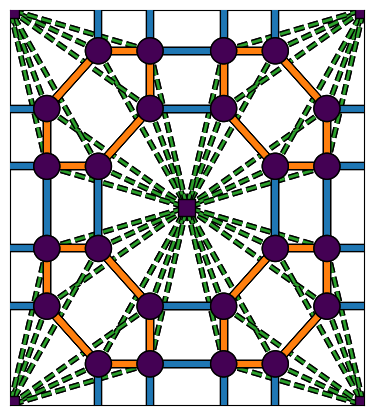

In [80]:
cs = []
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
            #cs.append(line[0].get_c())
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
            
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:,0], X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0], X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_RHO.pdf', bbox_inches='tight', dpi=1200);
plt.savefig('figures/weight_sharing_pore_RHO.png', bbox_inches='tight', dpi=1200);

In [77]:
len(np.unique(cs))

2